In [54]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [56]:
IMAGE_SIZE=256
BATCH_SIZE=100
CHANNELS=3
EPOCHS=10

In [57]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "C:\\Users\\JAYCHANDRA\\Downloads\\New folder\\dogImages",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7505 files belonging to 10 classes.


In [58]:
class_names=dataset.class_names
class_names

['001.Affenpinscher',
 '002.Afghan_hound',
 '003.Airedale_terrier',
 '004.Akita',
 '005.Alaskan_malamute',
 '006.American_eskimo_dog',
 '007.American_foxhound',
 '008.American_staffordshire_terrier',
 '009.German_shepherd_dog',
 '010.Pekingese']

In [59]:
len(dataset)

76

(100, 256, 256, 3)
[8 0 5 8 1 2 0 1 7 5 1 9 7 1 4 1 5 6 6 1 5 0 8 1 3 9 2 5 0 7 1 0 5 2 3 1 1
 3 7 5 4 6 4 0 5 3 4 3 0 8 5 6 5 7 4 0 6 8 7 4 3 4 2 8 9 7 4 5 7 6 4 1 2 9
 9 1 3 6 2 4 0 0 5 0 6 9 6 6 5 2 6 9 5 1 7 7 2 0 2 6]


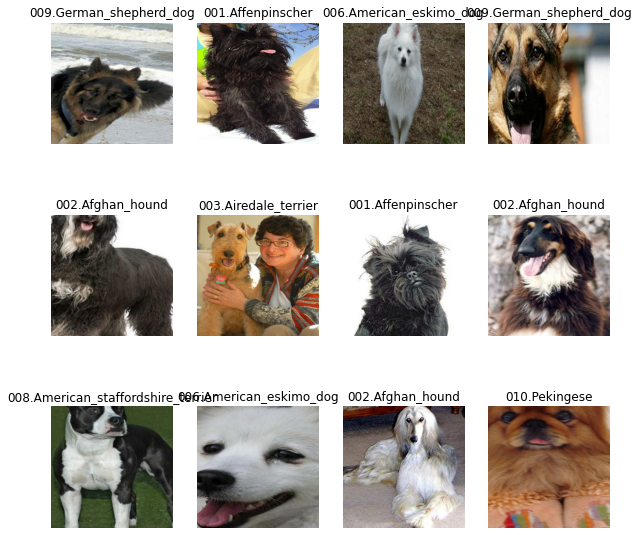

In [60]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [63]:
train_size=0.8
len(dataset)*train_size

60.800000000000004

In [64]:
train_ds=dataset.take(72)

len(train_ds)

72

In [65]:
val_size=0.1
len(dataset)*val_size

7.6000000000000005

In [66]:
test_ds=dataset.skip(72)


In [67]:
len(test_ds)

4

In [68]:
val_ds=test_ds.take(9)
len(val_ds)

4

In [69]:
test_ds=test_ds.skip(9)
len(test_ds)

0

In [70]:
def get_dataset_partitons_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    test_size=int(test_split*ds_size)
    train_ds=dataset.take(train_size)
    test_ds=dataset.skip(train_size)
    val_ds=test_ds.take(val_size)
    test_ds=test_ds.skip(val_size)
    return train_ds,val_ds,test_ds

In [71]:
train_ds,val_ds,test_ds=get_dataset_partitons_tf(dataset)

In [73]:
len(train_ds)

60

In [74]:
len(val_ds)

7

In [75]:
len(test_ds)

9

In [76]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [77]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [78]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=10
model=models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
    
])

model.build(input_shape=input_shape)

In [79]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (100, 256, 256, 3)        0         
                                                                 
 conv2d_12 (Conv2D)          (100, 254, 254, 32)       896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (100, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (100, 125, 125, 64)       18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (100, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (100, 60, 60, 64)        

In [80]:
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [81]:
from pathlib import Path
import imghdr

data_dir = "C:\\Users\\JAYCHANDRA\\Downloads\\New folder\\dogImages"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [82]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds  
)

Epoch 1/10
60/60 [==============================] - 297s 5s/step - loss: 2.1599 - accuracy: 0.2065 - val_loss: 1.9676 - val_accuracy: 0.3486
Epoch 2/10
60/60 [==============================] - 273s 5s/step - loss: 1.6175 - accuracy: 0.4327 - val_loss: 1.4060 - val_accuracy: 0.5000
Epoch 3/10
60/60 [==============================] - 276s 5s/step - loss: 1.2103 - accuracy: 0.5872 - val_loss: 0.9430 - val_accuracy: 0.7071
Epoch 4/10
60/60 [==============================] - 274s 5s/step - loss: 0.8506 - accuracy: 0.7143 - val_loss: 0.7600 - val_accuracy: 0.7371
Epoch 5/10
60/60 [==============================] - 281s 5s/step - loss: 0.5786 - accuracy: 0.8107 - val_loss: 0.8021 - val_accuracy: 0.7414
Epoch 6/10
60/60 [==============================] - 316s 5s/step - loss: 0.3521 - accuracy: 0.8853 - val_loss: 0.2975 - val_accuracy: 0.9029
Epoch 7/10
60/60 [==============================] - 306s 5s/step - loss: 0.2509 - accuracy: 0.9163 - val_loss: 0.2830 - val_accuracy: 0.9100
Epoch 8/10
60

In [83]:
import os
import cv2
def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                index=f.rfind('.')
                ext=f[index+1:].lower()
                if ext not in ext_list:
                    print('file ', f_path, ' has an invalid extension ', ext)
                    bad_ext.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir =r"C:\\Users\\JAYCHANDRA\\Downloads\\New folder\\dogImages"
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print(' no improper image files were found')

processing class directory  001.Affenpinscher
processing class directory  002.Afghan_hound
processing class directory  003.Airedale_terrier
processing class directory  004.Akita
processing class directory  005.Alaskan_malamute
processing class directory  006.American_eskimo_dog
processing class directory  007.American_foxhound
processing class directory  008.American_staffordshire_terrier
processing class directory  009.German_shepherd_dog
processing class directory  010.Pekingese
 no improper image files were found


In [84]:
scores=model.evaluate(test_ds)

9/9 [==============================] - 14s 628ms/step - loss: 0.2178 - accuracy: 0.9453


In [85]:
scores

[0.2177683264017105, 0.9453415870666504]

In [86]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 60}

In [87]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [88]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Train and Validation')

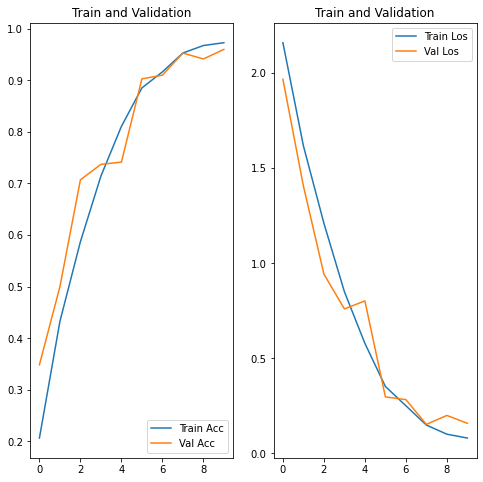

In [89]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Train Acc')
plt.plot(range(EPOCHS),val_acc,label='Val Acc')
plt.legend(loc='lower right')
plt.title('Train and Validation')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Train Los')
plt.plot(range(EPOCHS),val_loss,label='Val Los')
plt.legend(loc='upper right')
plt.title('Train and Validation')

In [92]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    predictions=model.predict(img_array)
    
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    
    return predicted_class,confidence

1/1 [==============================] - 0s 28ms/step


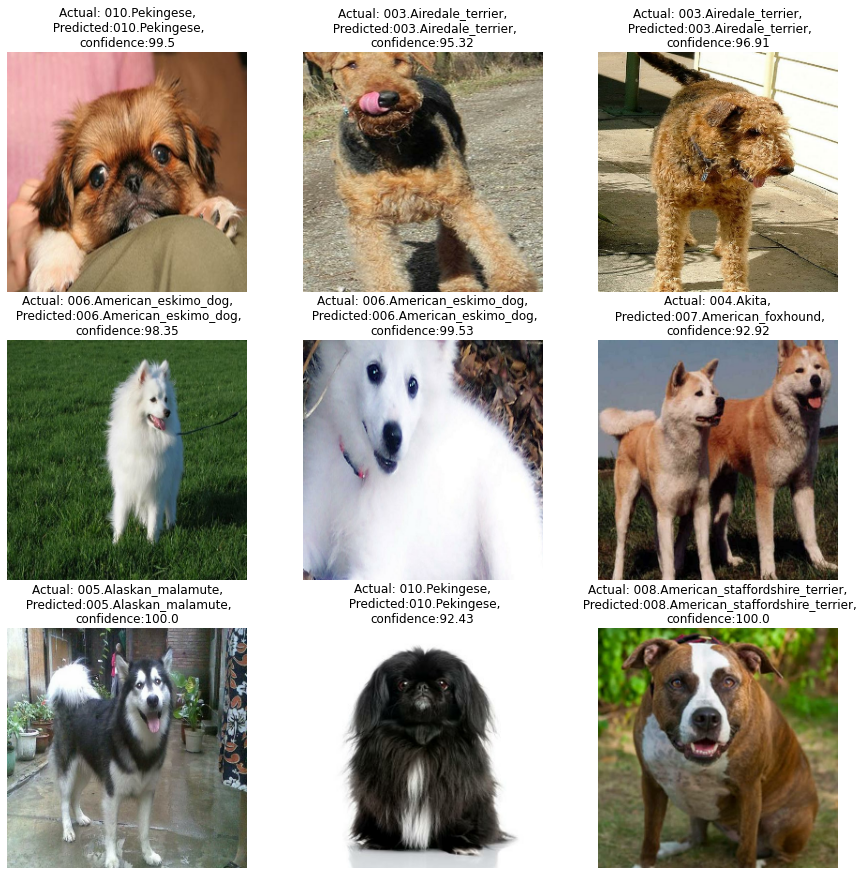

In [93]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted:{predicted_class},\nconfidence:{confidence}")
        
        plt.axis('off')

In [94]:
preds=model.predict(test_ds, verbose=1)

9/9 [==============================] - 6s 742ms/step


In [95]:
print(preds)

[[1.31189430e-04 4.22405731e-03 5.16422419e-03 ... 6.70947848e-05
  1.27220973e-01 8.63190234e-01]
 [1.58311869e-03 4.23248950e-03 7.87099198e-05 ... 8.27721960e-04
  1.49145699e-03 2.36611140e-06]
 [4.23704691e-12 6.08425944e-06 3.90765642e-08 ... 2.14097872e-02
  1.06321805e-08 2.37771998e-12]
 ...
 [1.37773473e-04 9.98568177e-01 6.24280714e-04 ... 1.81284813e-05
  1.20694940e-05 2.31128201e-04]
 [4.28222826e-14 1.45429058e-05 8.02978093e-07 ... 1.20344723e-03
  2.92359147e-07 2.52625365e-09]
 [4.89628817e-08 1.19937124e-06 9.80945725e-09 ... 8.23126466e-05
  7.87932475e-09 8.38590974e-10]]


In [96]:
for i,p in enumerate(preds[:5]):
    index=np.argmax(p)
    kclass=class_names[index]
    print(i)
    print(p)
    print(index)
    print(kclass)

0
[1.3118943e-04 4.2240573e-03 5.1642242e-03 3.7270894e-07 9.8050168e-10
 2.9190275e-07 1.5498647e-06 6.7094785e-05 1.2722097e-01 8.6319023e-01]
9
010.Pekingese
1
[1.5831187e-03 4.2324895e-03 7.8709920e-05 3.5035256e-03 9.8827517e-01
 4.8525430e-06 5.3443142e-07 8.2772196e-04 1.4914570e-03 2.3661114e-06]
4
005.Alaskan_malamute
2
[4.23704691e-12 6.08425944e-06 3.90765642e-08 4.88820615e-06
 7.52291381e-01 1.80456534e-13 2.26287857e-01 2.14097872e-02
 1.06321805e-08 2.37771998e-12]
4
005.Alaskan_malamute
3
[1.1195670e-09 9.0849979e-05 2.2069114e-05 7.1461801e-03 1.6700198e-03
 9.0400136e-01 9.2681994e-06 8.7060295e-02 4.5745859e-12 5.3708016e-09]
5
006.American_eskimo_dog
4
[1.5177481e-11 2.9190914e-12 4.4448559e-12 2.5424509e-07 2.4824767e-04
 1.5907508e-01 4.5481790e-03 8.3612823e-01 7.9728928e-14 4.6267086e-08]
7
008.American_staffordshire_terrier


In [97]:
num=[]
for i in range(10):
    num.append(i)

In [98]:

dic = dict(zip(class_names,num))
dic

{'001.Affenpinscher': 0,
 '002.Afghan_hound': 1,
 '003.Airedale_terrier': 2,
 '004.Akita': 3,
 '005.Alaskan_malamute': 4,
 '006.American_eskimo_dog': 5,
 '007.American_foxhound': 6,
 '008.American_staffordshire_terrier': 7,
 '009.German_shepherd_dog': 8,
 '010.Pekingese': 9}

In [99]:
li = list(dic.keys())
print(li)

['001.Affenpinscher', '002.Afghan_hound', '003.Airedale_terrier', '004.Akita', '005.Alaskan_malamute', '006.American_eskimo_dog', '007.American_foxhound', '008.American_staffordshire_terrier', '009.German_shepherd_dog', '010.Pekingese']


In [100]:
from tensorflow.keras.preprocessing import image
import numpy as np
class pridict:
    def __init__(self , path):
        image_path=path
        new_img = image.load_img(image_path)
        img = image.img_to_array(new_img)
        img = np.expand_dims(img, axis=0)

        print("Following is our prediction:")
        prediction = model.predict(img)
        # decode the results into a list of tuples (class, description, probability)
        # (one such list for each sample in the batch)
        d = prediction.flatten()
        j = d.max()
        for index,item in enumerate(d):
            if item == j:
                class_name = li[index]

        ##Another way
        # img_class = classifier.predict_classes(img)
        # img_prob = classifier.predict_proba(img)
        # print(img_class ,img_prob )


        #ploting image with predicted class name        
        plt.figure(figsize = (4,4))
        plt.imshow(new_img)
        plt.axis('off')
        plt.title(class_name)
        plt.show()

Following is our prediction:
1/1 [==============================] - 0s 28ms/step


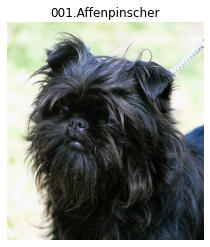

In [104]:
pridict("C:\\Users\\JAYCHANDRA\\Downloads\\dogImages\\dogImages\\test\\001.Affenpinscher\\Affenpinscher_00023.jpg")

Following is our prediction:
1/1 [==============================] - 0s 148ms/step


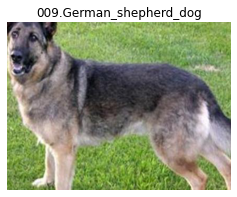

In [102]:
pridict("C:\\Users\\JAYCHANDRA\\Downloads\\New folder\\dogImages\\009.German_shepherd_dog\\009.German_shepherd_dog_original_071.German_shepherd_dog_original_German_shepherd_dog_04892.jpg_856683d4-506b-4da4-ae80-bbc8d408eb28.jpg_c606489e-8f8c-40c7-bda3-b09e9de56c8d.jpg")

Following is our prediction:
1/1 [==============================] - 0s 27ms/step


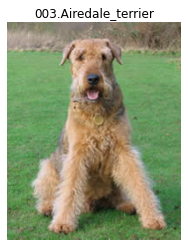

In [106]:
pridict("C:\\Users\\JAYCHANDRA\\Downloads\\dogImages\\dogImages\\test\\003.Airedale_terrier\\Airedale_terrier_00179.jpg")

Following is our prediction:
1/1 [==============================] - 0s 30ms/step


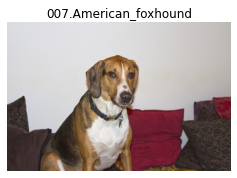

In [107]:
pridict("C:\\Users\\JAYCHANDRA\\Downloads\\dogImages\\dogImages\\test\\007.American_foxhound\\American_foxhound_00519.jpg")

Following is our prediction:
1/1 [==============================] - 0s 29ms/step


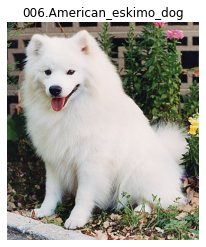

In [108]:
pridict("C:\\Users\\JAYCHANDRA\\Downloads\\dogImages\\dogImages\\test\\006.American_eskimo_dog\\American_eskimo_dog_00454.jpg")